In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import torch
import sys
sys.path.append("../..")
from modules.autoencoders import *
from modules.modelwithtrainer import *

In [3]:
# Loading data
inputFeature = pd.read_csv('../../../Data/NIBRS_ND_2021/processed/input.csv', index_col='Unnamed: 0')
# Separating numerical and categorical features
numerical_features=['population','victim_seq_num','age_num_victim','incident_hour','incident_month','incident_day','incident_dayofmonth','incident_weekofyear']
categorical_features = ['resident_status_code','race_desc_victim',
'ethnicity_name_victim','pub_agency_name','offense_name','location_name','weapon_name'
,'injury_name','relationship_name','incident_isweekend']
# Onehot-encoding categorical features
inputFeature_1h = pd.get_dummies(inputFeature, columns=categorical_features)

In [4]:
categorymapper = {
    "all_columns" : categorical_features,
    "all_indices" : [],
    "columns": {},
    "values": {}
}

for column in inputFeature_1h.columns:
    splitted_colname = column.split(" ")
    double_splitted_colname = splitted_colname[0].split("_")
    original_colname = "_".join(double_splitted_colname[:-1])
    if original_colname in categorical_features:
        first_value = double_splitted_colname[-1:]
        column_value = " ".join(first_value + splitted_colname[1:])
        column_index = inputFeature_1h.columns.get_loc(column)
        categorymapper["all_indices"].append(column_index)
        categorymapper["columns"].update({column_index:original_colname})
        categorymapper["values"].update({column_index:column_value})

In [6]:
# Convert object columns to numeric if they represent categories
for column in inputFeature_1h.select_dtypes(include=['object']):
    inputFeature_1h[column] = inputFeature_1h[column].astype('category').cat.codes

# Train-test split
train, test = train_test_split(inputFeature_1h, test_size=0.1, random_state=42)

# Scaling features
scaler = MinMaxScaler().fit(train[numerical_features])
train[numerical_features] = scaler.transform(train[numerical_features])
test[numerical_features] = scaler.transform(test[numerical_features])

# Converting data to tensors
X_train = torch.nan_to_num(torch.Tensor(train.values.astype(np.float32)))
y_train = torch.nan_to_num(torch.Tensor(train.values.astype(np.float32)))

X_test = torch.nan_to_num(torch.Tensor(test.values.astype(np.float32)))
y_test = torch.nan_to_num(torch.Tensor(test.values.astype(np.float32)))

In [7]:
# Dataloaders
trainset = MyDataset(X_train, y_train)
testset = MyDataset(X_test, y_test)
trainloader = DataLoader(trainset, batch_size=32, shuffle=True)
testloader = DataLoader(testset, batch_size=32, shuffle=False)

In [8]:
# Define sizes for the layers
layer_sizes = [229, 64, 32, 16]  # Example decreasing sizes for the encoder

# Create the encoder ModuleList
encoder = nn.ModuleList()
for i in range(len(layer_sizes) - 1):
    encoder.append(nn.Linear(layer_sizes[i], layer_sizes[i + 1]))
    encoder.append(nn.ReLU())

# Create the decoder ModuleList (mirror of the encoder)
decoder = nn.ModuleList()
for i in range(len(layer_sizes) - 1, 0, -1):
    decoder.append(nn.Linear(layer_sizes[i], layer_sizes[i - 1]))
    decoder.append(nn.ReLU())

# Remove the last ReLU from the decoder (optional, depending on use case)
decoder = decoder[:-1]
criterion = nn.MSELoss()
model = AutoEncoder(encoder, decoder)
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 5
print_every = 40
callbacks = [ModelCheckPoint(monitored_metric="val loss epoch",
                             minimize_metric=True),
            EarlyStopping(monitored_metric="val loss epoch",
                          minimize_metric=True,
                          patience=10)]

In [9]:
logs = model.fit(optimizer, criterion, epochs, trainloader, testloader, callbacks=callbacks, save_filename="autoencoder",
                 embed_hidden=True, categorymapper=categorymapper)

TensorBoard is already running at http://localhost:6006
step 40 - train loss: 0.0421
step 80 - train loss: 0.0269
step 120 - train loss: 0.0252
step 160 - train loss: 0.0233
step 200 - train loss: 0.0215
step 240 - train loss: 0.0196
step 280 - train loss: 0.0178
step 320 - train loss: 0.0168
step 360 - train loss: 0.0159
step 400 - train loss: 0.0150
step 440 - train loss: 0.0149
step 480 - train loss: 0.0145
epoch 0 - train loss: 0.0212
epoch 0 - val loss: 0.0144
val loss epoch decreased from inf to 0.014386933270715186
step 40 - train loss: 0.0140
step 80 - train loss: 0.0137
step 120 - train loss: 0.0139
step 160 - train loss: 0.0133
step 200 - train loss: 0.0129
step 240 - train loss: 0.0128
step 280 - train loss: 0.0123
step 320 - train loss: 0.0123
step 360 - train loss: 0.0123
step 400 - train loss: 0.0119
step 440 - train loss: 0.0115
step 480 - train loss: 0.0116
epoch 1 - train loss: 0.0127
epoch 1 - val loss: 0.0115
val loss epoch decreased from 0.014386933270715186 to 0.01

c:\Users\CSANADANSYS\Desktop\NN projekt\crime analysis\new\notebooks\test_modules\../..\modules\modelwithtrainer\callbacks.py:63: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.

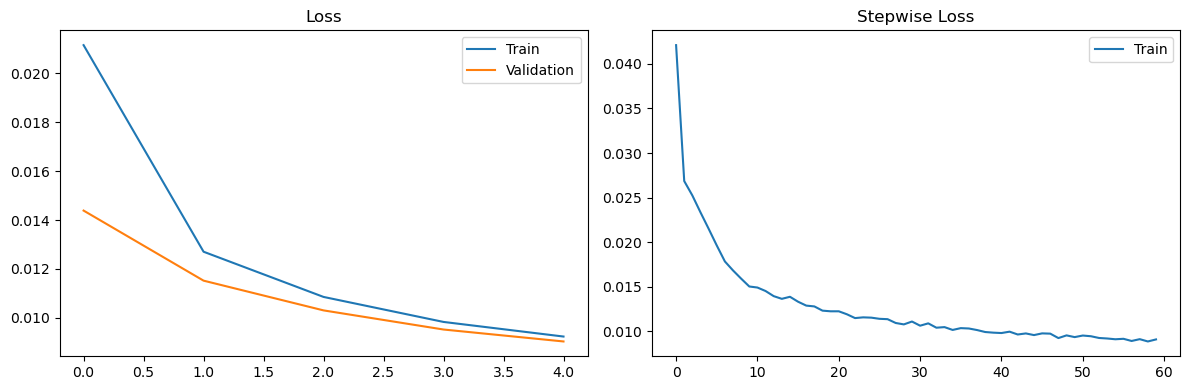

In [10]:
f, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(logs["train loss epoch"], label="Train")
ax[0].plot(logs["val loss epoch"], label="Validation")
ax[0].set_title("Loss")
ax[0].legend()
ax[1].plot(logs["train loss step"], label="Train")
ax[1].set_title("Stepwise Loss")
ax[1].legend()

plt.tight_layout()
plt.show()